In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
# 科学计算
from scipy.stats import skew, kurtosis
import pylab as py
import pandas as pd

# 时间
import time
import datetime
from datetime import datetime
from datetime import date
import calendar
# for ML:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier  #
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 # 评估特征重要性
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('data.csv')
#data.info()
# 查看缺失数据
#print(data.isnull().sum()[data.isnull().sum() != 0])
# 缺失值处理
# company 缺失太多，删除
# country、children和agent缺失比较少，用字段内的众数填充
# country和children用字段内的众数填充 agent缺失值用0填充，代表没有指定任何机构
data_new = data.copy(deep=True)
data_new.drop("company", axis=1, inplace=True)
data_new["agent"].fillna(0, inplace=True)
data_new["children"].fillna(data_new["children"].mode()[0], inplace=True)
data_new["country"].fillna(data_new["country"].mode()[0], inplace=True)
print("ok")
# print(data_new.isnull().sum()[data_new.isnull().sum() != 0])
# print(data_new.head(10))
# print(data_new[['children','agent','country']])
# data_new.info()
# print(data_new.isnull().sum()[data_new.isnull().sum() != 0])

# 处理一下异常值：成人+小孩+婴儿=0的情况都需要删掉
data_new["children"] = data_new["children"].astype(int)
data_new["agent"] = data_new["agent"].astype(int)  # 转换数据类型
zero_guests = list(data_new["adults"] + data_new["children"] + data_new["babies"] == 0)
data_new.drop(data_new.index[zero_guests], inplace=True)
# meal字段映射处理
data_new["meal"].replace(["Undefined", "BB", "FB", "HB", "SC"],["No Meal", "Breakfast", "Full Board", "Half Board", "No Meal"], inplace=True)
# 数据去重
#data_new.drop_duplicates(inplace=True)
#data_new.to_csv('data_new.csv')
#print(data.shape)
#print(data_new.shape)
#分离特征类型
num_features = ["lead_time","booking_changes","total_of_special_requests","required_car_parking_spaces","days_in_waiting_list",
                 "previous_cancellations","is_repeated_guest","adults","previous_bookings_not_canceled","agent",
                "adr","babies","stays_in_weekend_nights","arrival_date_week_number",
                "children","stays_in_week_nights"]

cat_features = ["hotel","meal","market_segment","country","assigned_room_type",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]
#分离特征和预测值
features = num_features + cat_features
X = data_new.drop(["is_canceled"], axis=1)[features]
y = data_new["is_canceled"]

# 预处理数值特征：
#整数型特征
# 对于大多数数值型的特征，用0填充缺失值
num_transformer = SimpleImputer(strategy="constant",fill_value=0)

# 分类型特征的预处理：
cat_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                                  ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# 数值和分类特征的预处理：
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),("cat", cat_transformer, cat_features)])

base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42)),
               ("LR_model", LogisticRegression(random_state=42,solver='liblinear')),
               ("XGB_model", XGBClassifier(random_state=42)),
              ("KNN_model",KNeighborsClassifier(n_neighbors=4, algorithm='auto', weights='distance')),
              ("AdaB_model",AdaBoostClassifier(random_state=None,base_estimator=None,  n_estimators=50, learning_rate=1.0, algorithm='SAMME.R'))]

# 将数据分成“stratifiedkfold”部分进行交叉验证，
# 使用shuffle确保数据的随机分布：
stratifiedkf = 10  
split = StratifiedKFold(n_splits=stratifiedkf, shuffle=True, random_state=42)

#对每个模型进行预处理、拟合、预测和评分：
for name, model in base_models:
    #将数据和模型的预处理打包到管道中：
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])

    #获取每个模型的交叉验证分数：
    cv_results = cross_val_score(model_steps, X, y, cv=split,scoring="accuracy")
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuracy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score},mean:{mean_score}")


ok
DT_model cross validation accuracy score: 0.8601 +/- 0.0027 (std) min: 0.8556, max: 0.8654,mean:0.8601
RF_model cross validation accuracy score: 0.8941 +/- 0.0023 (std) min: 0.8922, max: 0.9004,mean:0.8941
LR_model cross validation accuracy score: 0.8151 +/- 0.0023 (std) min: 0.8107, max: 0.8187,mean:0.8151
[23:30:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:15] WARNING: C:\Windows\Tem

ok
Enhanced RF model cross validation accuracy score: nan +/- nan (std) min: nan, max: nan, mean:nan, n_estimators: 0
Enhanced RF model cross validation accuracy score: 0.8862 +/- 0.0026 (std) min: 0.8827, max: 0.8903, mean:0.8862, n_estimators: 10
Enhanced RF model cross validation accuracy score: 0.8917 +/- 0.0021 (std) min: 0.8874, max: 0.8942, mean:0.8917, n_estimators: 20
Enhanced RF model cross validation accuracy score: 0.8931 +/- 0.0025 (std) min: 0.8894, max: 0.8961, mean:0.8931, n_estimators: 30
Enhanced RF model cross validation accuracy score: 0.8936 +/- 0.0027 (std) min: 0.889, max: 0.8978, mean:0.8936, n_estimators: 40
Enhanced RF model cross validation accuracy score: 0.8945 +/- 0.0023 (std) min: 0.8909, max: 0.898, mean:0.8945, n_estimators: 50
Enhanced RF model cross validation accuracy score: 0.895 +/- 0.0026 (std) min: 0.8914, max: 0.8988, mean:0.895, n_estimators: 60
Enhanced RF model cross validation accuracy score: 0.8949 +/- 0.0025 (std) min: 0.8916, max: 0.8986,

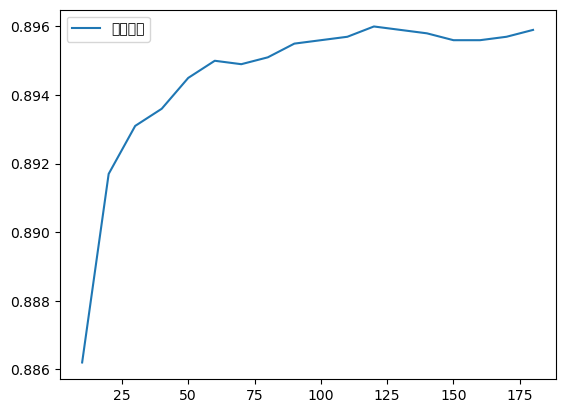

In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
# 科学计算
from scipy.stats import skew, kurtosis
import pylab as py
import pandas as pd

# 数据分析&绘图
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import warnings
# 时间
import time
import datetime
from datetime import datetime
from datetime import date
import calendar
# for ML:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier  #
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 # 评估特征重要性
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('data.csv')
#data.info()
# 查看缺失数据
#print(data.isnull().sum()[data.isnull().sum() != 0])
# 缺失值处理
# company 缺失太多，删除
# country、children和agent缺失比较少，用字段内的众数填充
# country和children用字段内的众数填充 agent缺失值用0填充，代表没有指定任何机构
data_new = data.copy(deep=True)
data_new.drop("company", axis=1, inplace=True)
data_new["agent"].fillna(0, inplace=True)
data_new["children"].fillna(data_new["children"].mode()[0], inplace=True)
data_new["country"].fillna(data_new["country"].mode()[0], inplace=True)
print("ok")
# print(data_new.isnull().sum()[data_new.isnull().sum() != 0])
# print(data_new.head(10))
# print(data_new[['children','agent','country']])
# data_new.info()
# print(data_new.isnull().sum()[data_new.isnull().sum() != 0])

# 处理一下异常值：成人+小孩+婴儿=0的情况都需要删掉
data_new["children"] = data_new["children"].astype(int)
data_new["agent"] = data_new["agent"].astype(int)  # 转换数据类型
zero_guests = list(data_new["adults"] + data_new["children"] + data_new["babies"] == 0)
data_new.drop(data_new.index[zero_guests], inplace=True)
# meal字段映射处理
data_new["meal"].replace(["Undefined", "BB", "FB", "HB", "SC"],["No Meal", "Breakfast", "Full Board", "Half Board", "No Meal"], inplace=True)
# 数据去重
#data_new.drop_duplicates(inplace=True)
#data_new.to_csv('data_new.csv')
#print(data.shape)
#print(data_new.shape)
#分离特征类型
num_features = ["lead_time","booking_changes","total_of_special_requests","required_car_parking_spaces","days_in_waiting_list",
                 "previous_cancellations","is_repeated_guest","adults","previous_bookings_not_canceled","agent",
                "adr","babies","stays_in_weekend_nights","arrival_date_week_number",
                "children","stays_in_week_nights"]

cat_features = ["hotel","meal","market_segment","country","assigned_room_type",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]
#分离特征和预测值
features = num_features + cat_features
X = data_new.drop(["is_canceled"], axis=1)[features]
y = data_new["is_canceled"]

# 预处理数值特征：
#整数型特征
# 对于大多数数值型的特征，用0填充缺失值
num_transformer = SimpleImputer(strategy="constant",fill_value=0)

# 分类型特征的预处理：
cat_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                                  ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# 数值和分类特征的预处理：
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),("cat", cat_transformer, cat_features)])

# 将数据分成“stratifiedkfold”部分进行交叉验证，
# 使用shuffle确保数据的随机分布：
stratifiedkf = 10  
split = StratifiedKFold(n_splits=stratifiedkf, shuffle=True, random_state=42)

rfc_s = []
for i in range(0, 181, 10):
    rf_model_enh = RandomForestClassifier(n_estimators=i,max_features=0.4,min_samples_split=2,random_state=42)
    split = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    model_pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', rf_model_enh)])
    cv_results = cross_val_score(model_pipe, X, y, cv=split,scoring="accuracy",n_jobs=-1)
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"Enhanced RF model cross validation accuracy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}, mean:{mean_score}, n_estimators: {i}")
    rfc_s.append(mean_score)
plt.plot(range(0,181,10),rfc_s,label='随机森林')
plt.legend()

In [2]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
# 科学计算
from scipy.stats import skew, kurtosis
import pylab as py
import pandas as pd
# 时间
import time
import datetime
from datetime import datetime
from datetime import date
import calendar
# for ML:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier  #
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 # 评估特征重要性
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('data.csv')
#data.info()
# 查看缺失数据
#print(data.isnull().sum()[data.isnull().sum() != 0])
# 缺失值处理
# company 缺失太多，删除
# country、children和agent缺失比较少，用字段内的众数填充
# country和children用字段内的众数填充 agent缺失值用0填充，代表没有指定任何机构
data_new = data.copy(deep=True)
data_new.drop("company", axis=1, inplace=True)
data_new["agent"].fillna(0, inplace=True)
data_new["children"].fillna(data_new["children"].mode()[0], inplace=True)
data_new["country"].fillna(data_new["country"].mode()[0], inplace=True)
print("ok")
# print(data_new.isnull().sum()[data_new.isnull().sum() != 0])
# print(data_new.head(10))
# print(data_new[['children','agent','country']])
# data_new.info()
# print(data_new.isnull().sum()[data_new.isnull().sum() != 0])

# 处理一下异常值：成人+小孩+婴儿=0的情况都需要删掉
data_new["children"] = data_new["children"].astype(int)
data_new["agent"] = data_new["agent"].astype(int)  # 转换数据类型
zero_guests = list(data_new["adults"] + data_new["children"] + data_new["babies"] == 0)
data_new.drop(data_new.index[zero_guests], inplace=True)
# meal字段映射处理
data_new["meal"].replace(["Undefined", "BB", "FB", "HB", "SC"],["No Meal", "Breakfast", "Full Board", "Half Board", "No Meal"], inplace=True)
# 数据去重
#data_new.drop_duplicates(inplace=True)
#data_new.to_csv('data_new.csv')
#print(data.shape)
#print(data_new.shape)
#分离特征类型
num_features = ["lead_time","booking_changes","total_of_special_requests","required_car_parking_spaces","days_in_waiting_list",
                 "previous_cancellations","is_repeated_guest","adults","previous_bookings_not_canceled","agent",
                "adr","babies","stays_in_weekend_nights","arrival_date_week_number",
                "children","stays_in_week_nights"]

cat_features = ["hotel","meal","market_segment","country","assigned_room_type",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]
#分离特征和预测值
features = num_features + cat_features
X = data_new.drop(["is_canceled"], axis=1)[features]
y = data_new["is_canceled"]

# 预处理数值特征：
#整数型特征
# 对于大多数数值型的特征，用0填充缺失值
num_transformer = SimpleImputer(strategy="constant",fill_value=0)

# 分类型特征的预处理：
cat_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                                  ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# 数值和分类特征的预处理：
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),("cat", cat_transformer, cat_features)])

# 将数据分成“stratifiedkfold”部分进行交叉验证，
# 使用shuffle确保数据的随机分布：
stratifiedkf = 10  
split = StratifiedKFold(n_splits=stratifiedkf, shuffle=True, random_state=42)

#parameters = {'n_estimators':[118、119、121、122]}
print("118")
rf_model_enh = RandomForestClassifier(n_estimators=118,max_features=0.4,min_samples_split=2,random_state=42)
split = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, X, y, cv=split,scoring="accuracy",n_jobs=-1)
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}, mean:{mean_score}")

print("119")
rf_model_enh = RandomForestClassifier(n_estimators=119,max_features=0.4,min_samples_split=2,random_state=42)
split = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, X, y, cv=split,scoring="accuracy",n_jobs=-1)
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}, mean:{mean_score}")

print("121")
rf_model_enh = RandomForestClassifier(n_estimators=121,max_features=0.4,min_samples_split=2,random_state=42)
split = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, X, y, cv=split,scoring="accuracy",n_jobs=-1)
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}, mean:{mean_score}")

print("122")
rf_model_enh = RandomForestClassifier(n_estimators=122,max_features=0.4,min_samples_split=2,random_state=42)
split = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, X, y, cv=split,scoring="accuracy",n_jobs=-1)
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}, mean:{mean_score}")



ok
118
Enhanced RF model cross validation accuarcy score: 0.8959 +/- 0.0022 (std) min: 0.893, max: 0.9001, mean:0.8959
119
Enhanced RF model cross validation accuarcy score: 0.8959 +/- 0.0023 (std) min: 0.8924, max: 0.8998, mean:0.8959
121
Enhanced RF model cross validation accuarcy score: 0.8958 +/- 0.0023 (std) min: 0.8928, max: 0.8999, mean:0.8958
122
Enhanced RF model cross validation accuarcy score: 0.8959 +/- 0.0024 (std) min: 0.8929, max: 0.9, mean:0.8959


In [4]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
# 科学计算
from scipy.stats import skew, kurtosis
import pylab as py
import pandas as pd
# 时间
import time
import datetime
from datetime import datetime
from datetime import date
import calendar
# for ML:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier  #
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 # 评估特征重要性
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('data.csv')
#data.info()
# 查看缺失数据
#print(data.isnull().sum()[data.isnull().sum() != 0])
# 缺失值处理
# company 缺失太多，删除
# country、children和agent缺失比较少，用字段内的众数填充
# country和children用字段内的众数填充 agent缺失值用0填充，代表没有指定任何机构
data_new = data.copy(deep=True)
data_new.drop("company", axis=1, inplace=True)
data_new["agent"].fillna(0, inplace=True)
data_new["children"].fillna(data_new["children"].mode()[0], inplace=True)
data_new["country"].fillna(data_new["country"].mode()[0], inplace=True)
print("ok")
# print(data_new.isnull().sum()[data_new.isnull().sum() != 0])
# print(data_new.head(10))
# print(data_new[['children','agent','country']])
# data_new.info()
# print(data_new.isnull().sum()[data_new.isnull().sum() != 0])

# 处理一下异常值：成人+小孩+婴儿=0的情况都需要删掉
data_new["children"] = data_new["children"].astype(int)
data_new["agent"] = data_new["agent"].astype(int)  # 转换数据类型
zero_guests = list(data_new["adults"] + data_new["children"] + data_new["babies"] == 0)
data_new.drop(data_new.index[zero_guests], inplace=True)
# meal字段映射处理
data_new["meal"].replace(["Undefined", "BB", "FB", "HB", "SC"],["No Meal", "Breakfast", "Full Board", "Half Board", "No Meal"], inplace=True)
# 数据去重
#data_new.drop_duplicates(inplace=True)
#data_new.to_csv('data_new.csv')
#print(data.shape)
#print(data_new.shape)
#分离特征类型
num_features = ["lead_time","booking_changes","total_of_special_requests","required_car_parking_spaces","days_in_waiting_list",
                 "previous_cancellations","is_repeated_guest","adults","previous_bookings_not_canceled","agent",
                "adr","babies","stays_in_weekend_nights",
                "children","stays_in_week_nights"]

cat_features = ["hotel","meal","market_segment","country","assigned_room_type",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]
#分离特征和预测值
features = num_features + cat_features
X = data_new.drop(["is_canceled"], axis=1)[features]
y = data_new["is_canceled"]

# 预处理数值特征：
#整数型特征
# 对于大多数数值型的特征，用0填充缺失值
num_transformer = SimpleImputer(strategy="constant",fill_value=0)

# 分类型特征的预处理：
cat_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                                  ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# 数值和分类特征的预处理：
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),("cat", cat_transformer, cat_features)])

# 将数据分成“stratifiedkfold”部分进行交叉验证，
# 使用shuffle确保数据的随机分布：
stratifiedkf = 10  
split = StratifiedKFold(n_splits=stratifiedkf, shuffle=True, random_state=42)
rf_model_enh = RandomForestClassifier(n_estimators=120,max_features=0.4,min_samples_split=2,random_state=42)
split = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, X, y, cv=split,scoring="accuracy",n_jobs=-1)
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}, mean:{mean_score}")
#拟合模型，以便可以访问值：
model_pipe.fit(X,y)

#需要所有（编码）功能的名称。
#从一个热编码中获取列的名称：
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

#为完整列表添加num_功能。
#顺序必须与X的定义相同，其中num_特征是第一个：
feat_imp_list = num_features + onehot_columns

#显示10个最重要的功能，提供功能名称：
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
print(feat_imp_df.head(10))




ok
Enhanced RF model cross validation accuarcy score: 0.891 +/- 0.0027 (std) min: 0.8872, max: 0.8957, mean:0.891
                     feature    weight       std
0                  lead_time  0.146739  0.014666
1    deposit_type_Non Refund  0.121359  0.107476
2                        adr  0.100540  0.003240
3    deposit_type_No Deposit  0.083718  0.104972
4                country_PRT  0.065081  0.029661
5                      agent  0.054212  0.011421
6  total_of_special_requests  0.050366  0.010703
7       stays_in_week_nights  0.040145  0.002162
8   market_segment_Online TA  0.036139  0.016091
9     previous_cancellations  0.027699  0.014852
